# Poisson disc sampling

Quality meshes are important for producing reliable solution in surface process modelling. For any given node in an unstructured mesh, its neighbours should be spaced more or less at an equal radius. For this we turn to Poisson disc sampling using an efficient $O(N)$ [algorithm](http://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf).

The premise of this algorithm is to ensure that points are tightly packed together, but no closer than a specified minimum distance. This distance can be uniform across the entire domain, or alternatively a 2D numpy array of radius lengths can be used to bunch and relax the spacing of nodes.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
%matplotlib inline

## Uniform spacing

3019 points


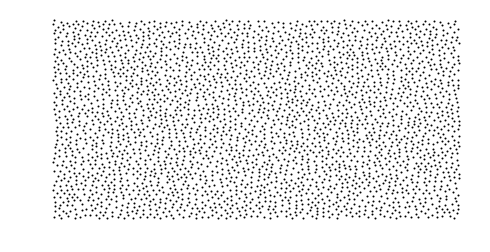

In [3]:
width, height = 800, 600
pts = meshtools.poisson_disc_sampler(width, height, radius=10.0)
print("{} points".format(pts.shape[0]))

fig = plt.figure(1, figsize=(8,4))
ax = fig.add_subplot(111)
ax.axis('off')
ax.scatter(pts[:,0], pts[:,1], s=1, c='k')
plt.show()

## Variable spacing

This is a *Poisson* disc sampler, so we sample fish...

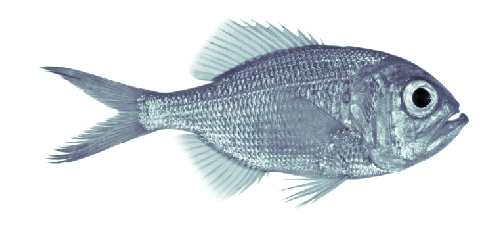

In [4]:
img = imread('data/fish.jpg', mode='F')
img = np.flipud(img)

height, width = img.shape

fig = plt.figure(1, figsize=(8,4))
ax = fig.add_subplot(111)
ax.axis('off')
ax.imshow(img, cmap='bone', origin='lower')
plt.show()

We adjust the numpy array to create sensible radii

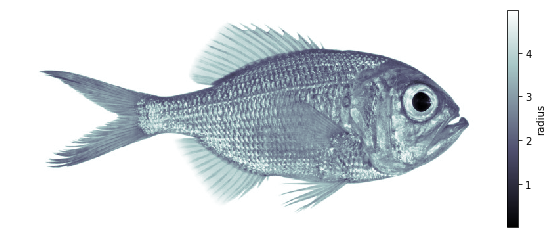

In [5]:
radius = img - img.min()
radius /= img.max()/5
radius += 1e-8

fig = plt.figure(1, figsize=(10,4))
ax = fig.add_subplot(111)
ax.axis('off')
im = ax.imshow(radius, cmap='bone', origin='lower')
fig.colorbar(im, ax=ax, label='radius')
plt.show()

In [6]:
# weight.fill(10.)
pts = meshtools.poisson_disc_sampler(width, height, radius=None, r_grid=radius)
print("number of points is {}".format(pts.shape[0]))

number of points is 9903


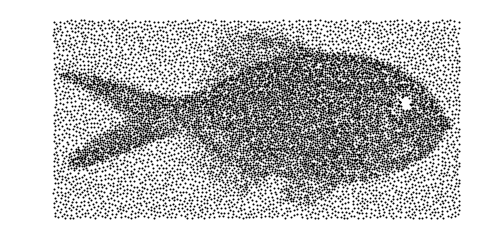

In [7]:
fig = plt.figure(1, figsize=(8,4))
ax = fig.add_subplot(111)
ax.axis('off')
ax.scatter(pts[:,0], pts[:,1], s=1, c='k')
plt.show()

### Landscape

In this example we create higher resolution where the slope is steeper.

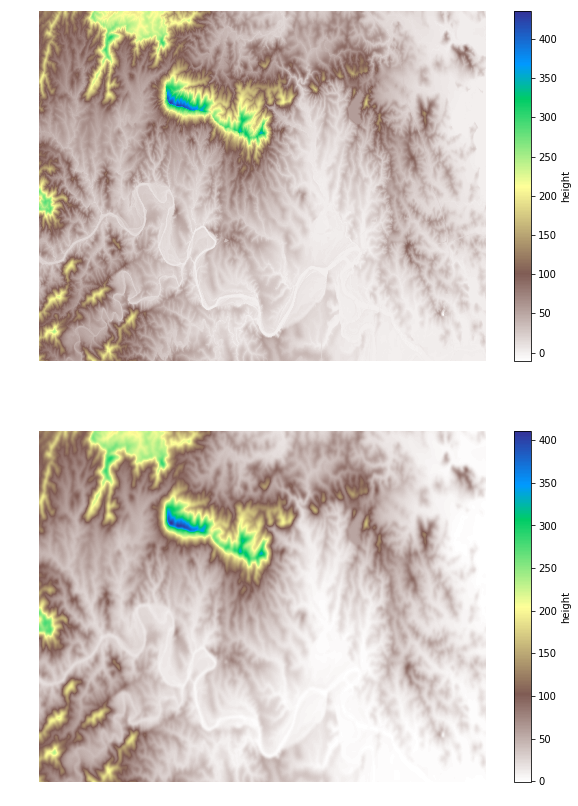

In [8]:
dem = imread('data/port_macquarie.tif', mode='F')

rows, columns = dem.shape
aspect_ratio = float(columns) / float(rows)

# apply gaussian filter for better results
# from scipy.ndimage import gaussian_filter
# radius = gaussian_filter(radius, 5.)

# radius -= slope.min()
# radius /= slope.max()/100
# radius += 1e-8

fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,10*aspect_ratio), )

ax.axis('off')
im = ax.imshow(dem, cmap='terrain_r', origin='lower', aspect=aspect_ratio)
fig.colorbar(im, ax=ax, label='height')

from scipy.ndimage import gaussian_filter
dem2 = gaussian_filter(dem, 10.)

ax2.axis('off')
im2 = ax2.imshow(dem2, cmap='terrain_r', origin='lower', aspect=aspect_ratio)
fig.colorbar(im2, ax=ax2, label='height')
plt.show()




In [9]:
gradX, gradY = np.gradient(dem2, 5., 5.) # 5m resolution in each direction
slope = np.hypot(gradX, gradY)

gradX, gradY = np.gradient(slope, 5., 5.) # 5m resolution in each direction
slope2 = np.hypot(gradX, gradY)


In [10]:
print slope.min(), slope.max()
print slope2.min(), slope2.max()

2.04709e-06 1.0137
3.88218e-10 0.0130033


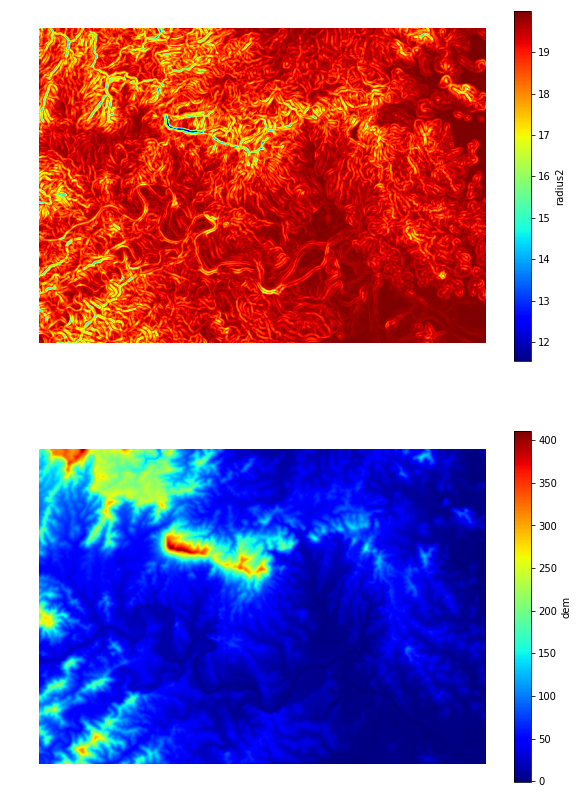

In [11]:
height, width = slope.shape

radius_min = 10.0
radius_max = 20.0

radius = 1.0/(slope2 + 0.02)
radius = (radius - radius.min()) / (radius.max() - radius.min()) 
radius = radius * (radius_max-radius_min) + radius_min

# apply gaussian filter for better results
from scipy.ndimage import gaussian_filter
radius2 = gaussian_filter(radius, 5.)

# radius -= slope.min()
# radius /= slope.max()/100
# radius += 1e-8

fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,10*aspect_ratio), )

ax.axis('off')
im = ax.imshow((radius2), cmap='jet', origin='lower')
fig.colorbar(im, ax=ax, label='radius2')

ax2.axis('off')
im = ax2.imshow(dem2, cmap='jet', origin='lower')
fig.colorbar(im, ax=ax2, label='dem')

plt.show()

In [12]:
pts = meshtools.poisson_disc_sampler(width, height, radius=5.0) # *0.75)



KeyboardInterrupt: 

In [ ]:
pts.shape

In [ ]:
## Boundary points.
##  - Build a tree ... 
##  - Traverse the bounding box
##  - nearest points to the box are bpoints
##  - This algorithm is fragile but works for this particular case

from scipy.spatial import cKDTree

meshTree = cKDTree(pts)

xmin = pts[:,0].min()
xmax = pts[:,0].max()
ymin = pts[:,1].min()
ymax = pts[:,1].max()

bmask = np.ones(pts.shape[0], dtype='Bool')

for x in np.linspace(xmin, xmax, 1000):
    pt1 = (x, ymin)
    pt2 = (x, ymax)
    dist, pt = meshTree.query(pt1)
    bmask[pt] = False
    dist, pt = meshTree.query(pt2)
    bmask[pt] = False

    
for y in np.linspace(ymin, ymax, 1000):
    pt1 = (xmin,y)
    pt2 = (xmax,y)
    dist, pt = meshTree.query(pt1)
    bmask[pt] = False
    dist, pt = meshTree.query(pt2)
    bmask[pt] = False


In [ ]:
from scipy import ndimage

coords = np.stack((pts[:,1], pts[:,0])).T
meshheights = ndimage.map_coordinates(dem2, coords.T, order=3, mode='nearest')

# Check this ... 
fig = plt.figure(1, figsize=(40,20.5))
ax = fig.add_subplot(111)
ax.axis('off')
sc = ax.scatter(pts[:,0], pts[:,1], c=meshheights, s=5)
sc = ax.scatter(pts[~bmask,0], pts[~bmask,1], c=meshheights[~bmask], s=25)

fig.colorbar(sc, ax=ax, label='height')

plt.show()

Now the points can be triangulated to become a quality unstructured mesh.

In [ ]:
from quagmire import TopoMesh # all routines we need are within this class
from quagmire import SurfaceProcessMesh

dm = meshtools.create_DMPlex_from_points(pts[:,0]*5.0, pts[:,1]*5.0, bmask=bmask)
mesh = SurfaceProcessMesh(dm)
mesh.update_height(meshheights)


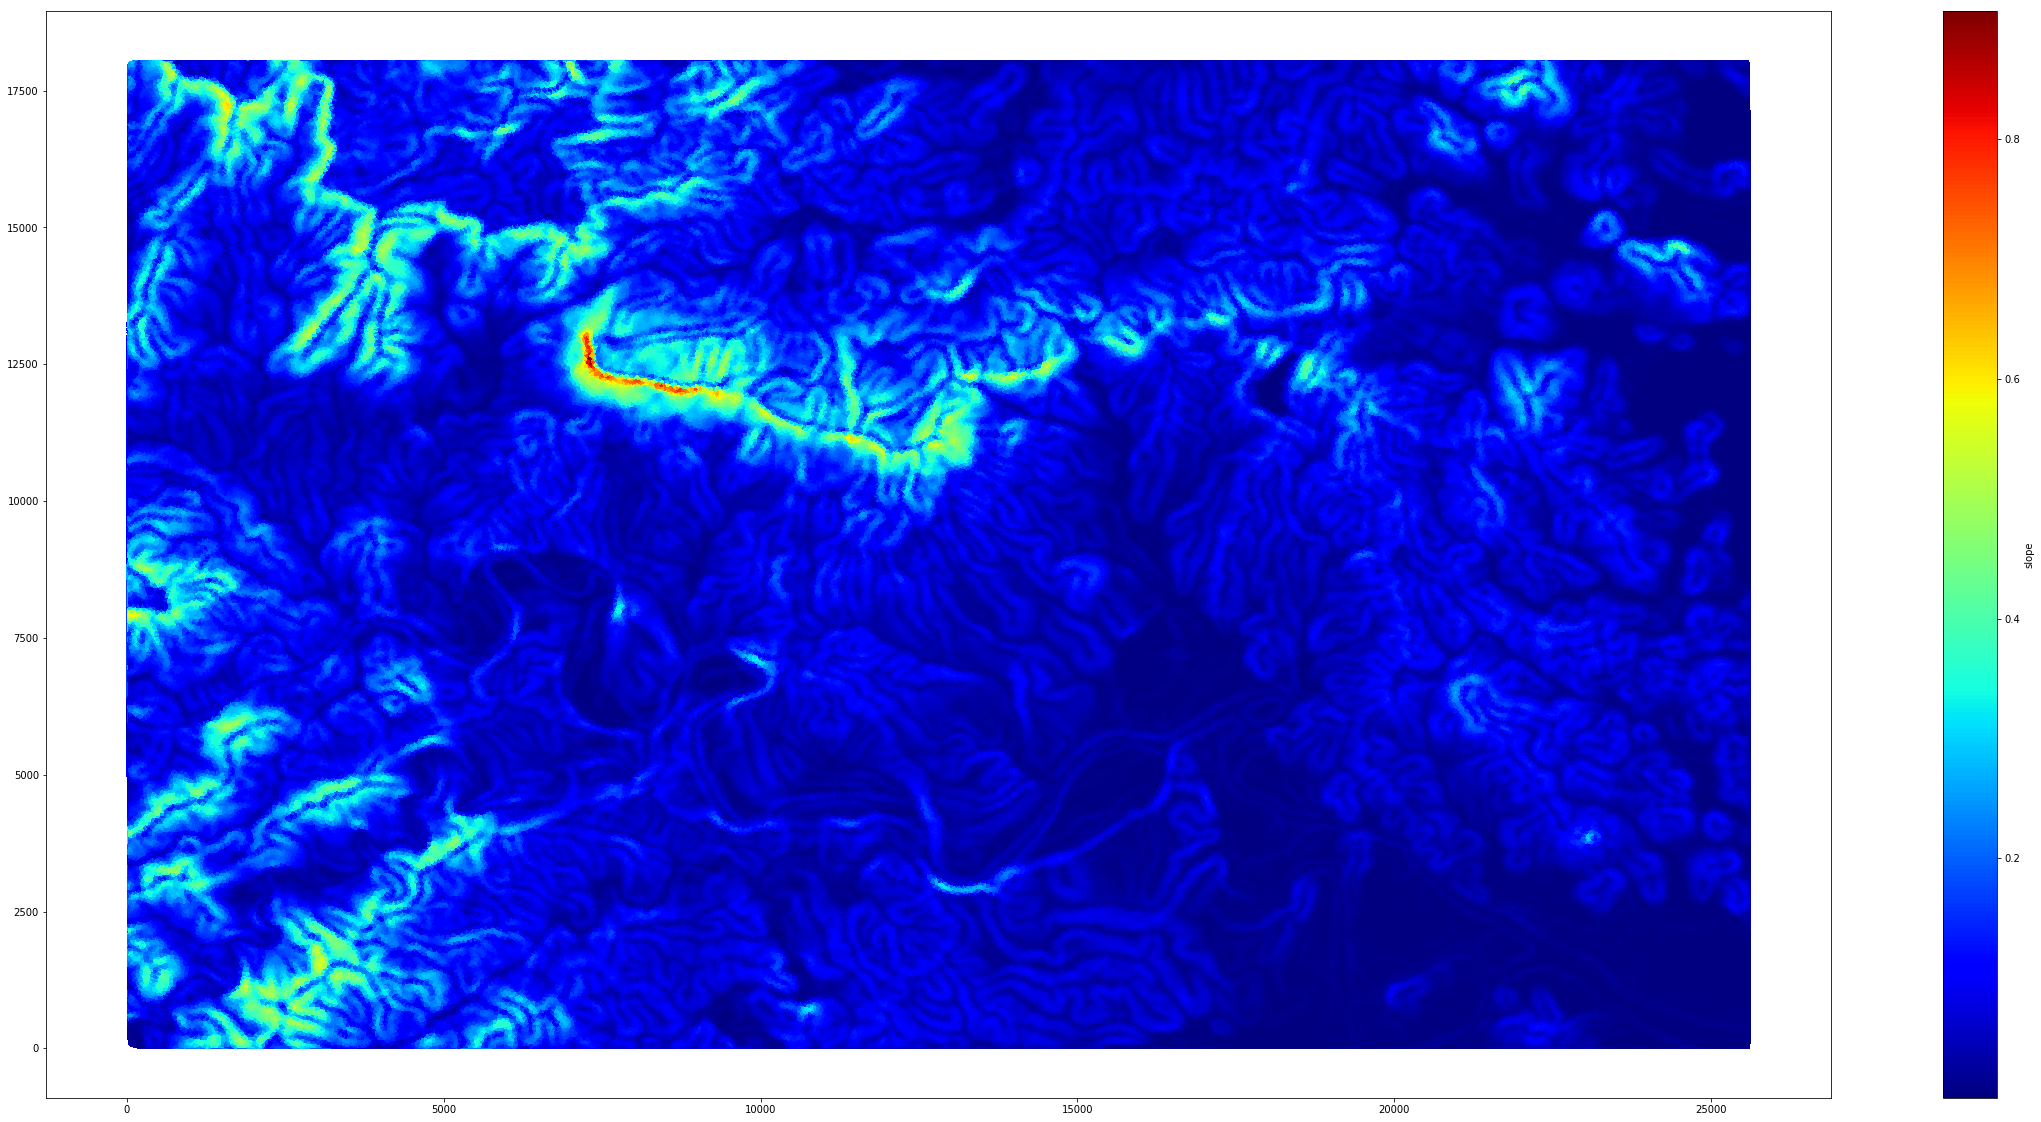

In [27]:
fig, (ax1) = plt.subplots(1,1, figsize=(40,20))

s = ax1.tripcolor(mesh.tri.points[:,0], mesh.tri.points[:,1], mesh.tri.simplices, mesh.slope, linewidth=0.1, 
              cmap='jet')

fig.colorbar(s, ax=ax1, label='slope')

In [38]:
gradient_max = mesh.slope.max()
gradient_mean = mesh.slope.mean()
flat_spots = np.where(mesh.slope < gradient_mean*0.01)[0]
print gradient_mean

print flat_spots.shape

0.091563423944
(1605,)


In [35]:
low_points = mesh.identify_low_points()
print "Number of low points: ", low_points.shape[0]
print mesh.slope[low_points].mean()

nodes = np.arange(0, mesh.npoints)
lows =  np.where(mesh.down_neighbour1 == nodes)[0]

print mesh.slope[lows], mesh.slope.max()

Number of low points:  254
0.00879095407911
[  2.11879276e-02   3.97556536e-02   1.72810882e-01   2.79572345e-02
   4.46332768e-02   6.93438947e-02   8.33978318e-03   1.42083515e-03
   9.93815996e-03   2.57602073e-02   3.35408524e-02   1.15507515e-02
   1.86717454e-02   5.72321303e-02   1.68567188e-02   3.54423784e-02
   1.31012443e-02   4.25758325e-02   9.06778313e-03   1.50451642e-02
   1.79416668e-02   9.66372062e-03   1.41158644e-02   1.78805999e-02
   1.20485565e-02   1.45743387e-02   8.06649402e-03   1.07830167e-02
   1.28646791e-02   2.14010105e-02   1.93798579e-02   2.75113154e-03
   1.24566779e-02   8.17083567e-03   1.09073296e-02   2.45140726e-03
   3.11018247e-02   6.57591643e-03   4.85397056e-02   2.82041002e-02
   2.54572812e-03   5.67365577e-03   1.30533595e-02   1.69574637e-02
   6.07089465e-03   7.78179243e-03   4.12305072e-03   2.54898961e-03
   3.51788886e-02   2.02268343e-02   1.71300843e-02   1.46535011e-02
   1.58490650e-02   2.52870042e-02   1.23427960e-03   2.092

In [30]:
flow = mesh.cumulative_flow((1.0 * mesh.area))

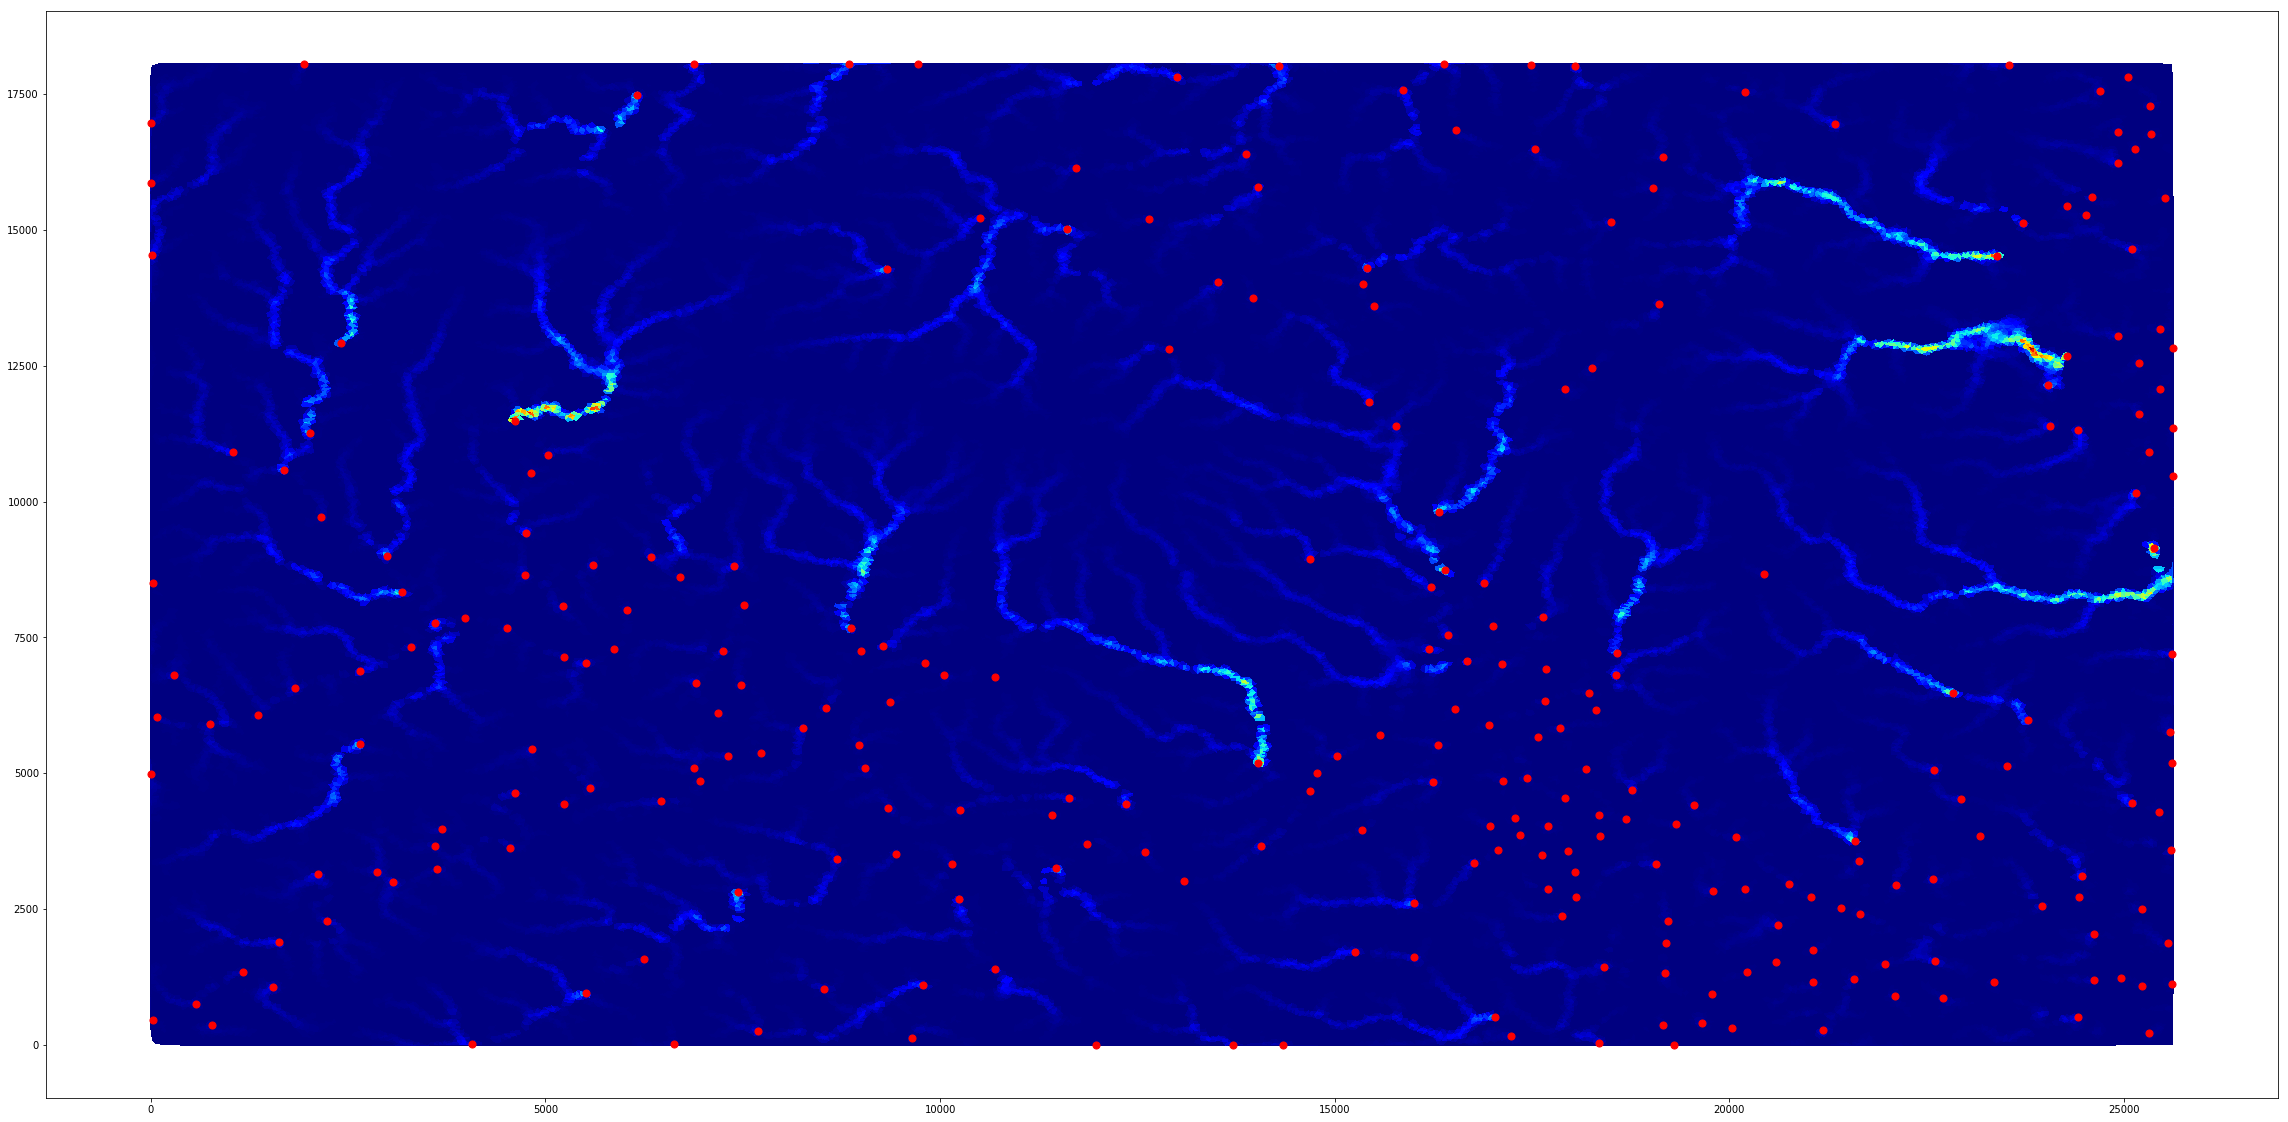

In [31]:
fig, (ax1) = plt.subplots(1,1, figsize=(40,20))

ax1.tripcolor(mesh.tri.points[:,0], mesh.tri.points[:,1], mesh.tri.simplices, 
              flow, linewidth=0.1, cmap='jet')

ax1.scatter(mesh.tri.points[lows,0], mesh.tri.points[lows,1], color="Red", s=50)
# ax1.scatter(mesh.tri.points[flat_spots,0], mesh.tri.points[flat_spots,1], marker="o", color="Red", s=50)

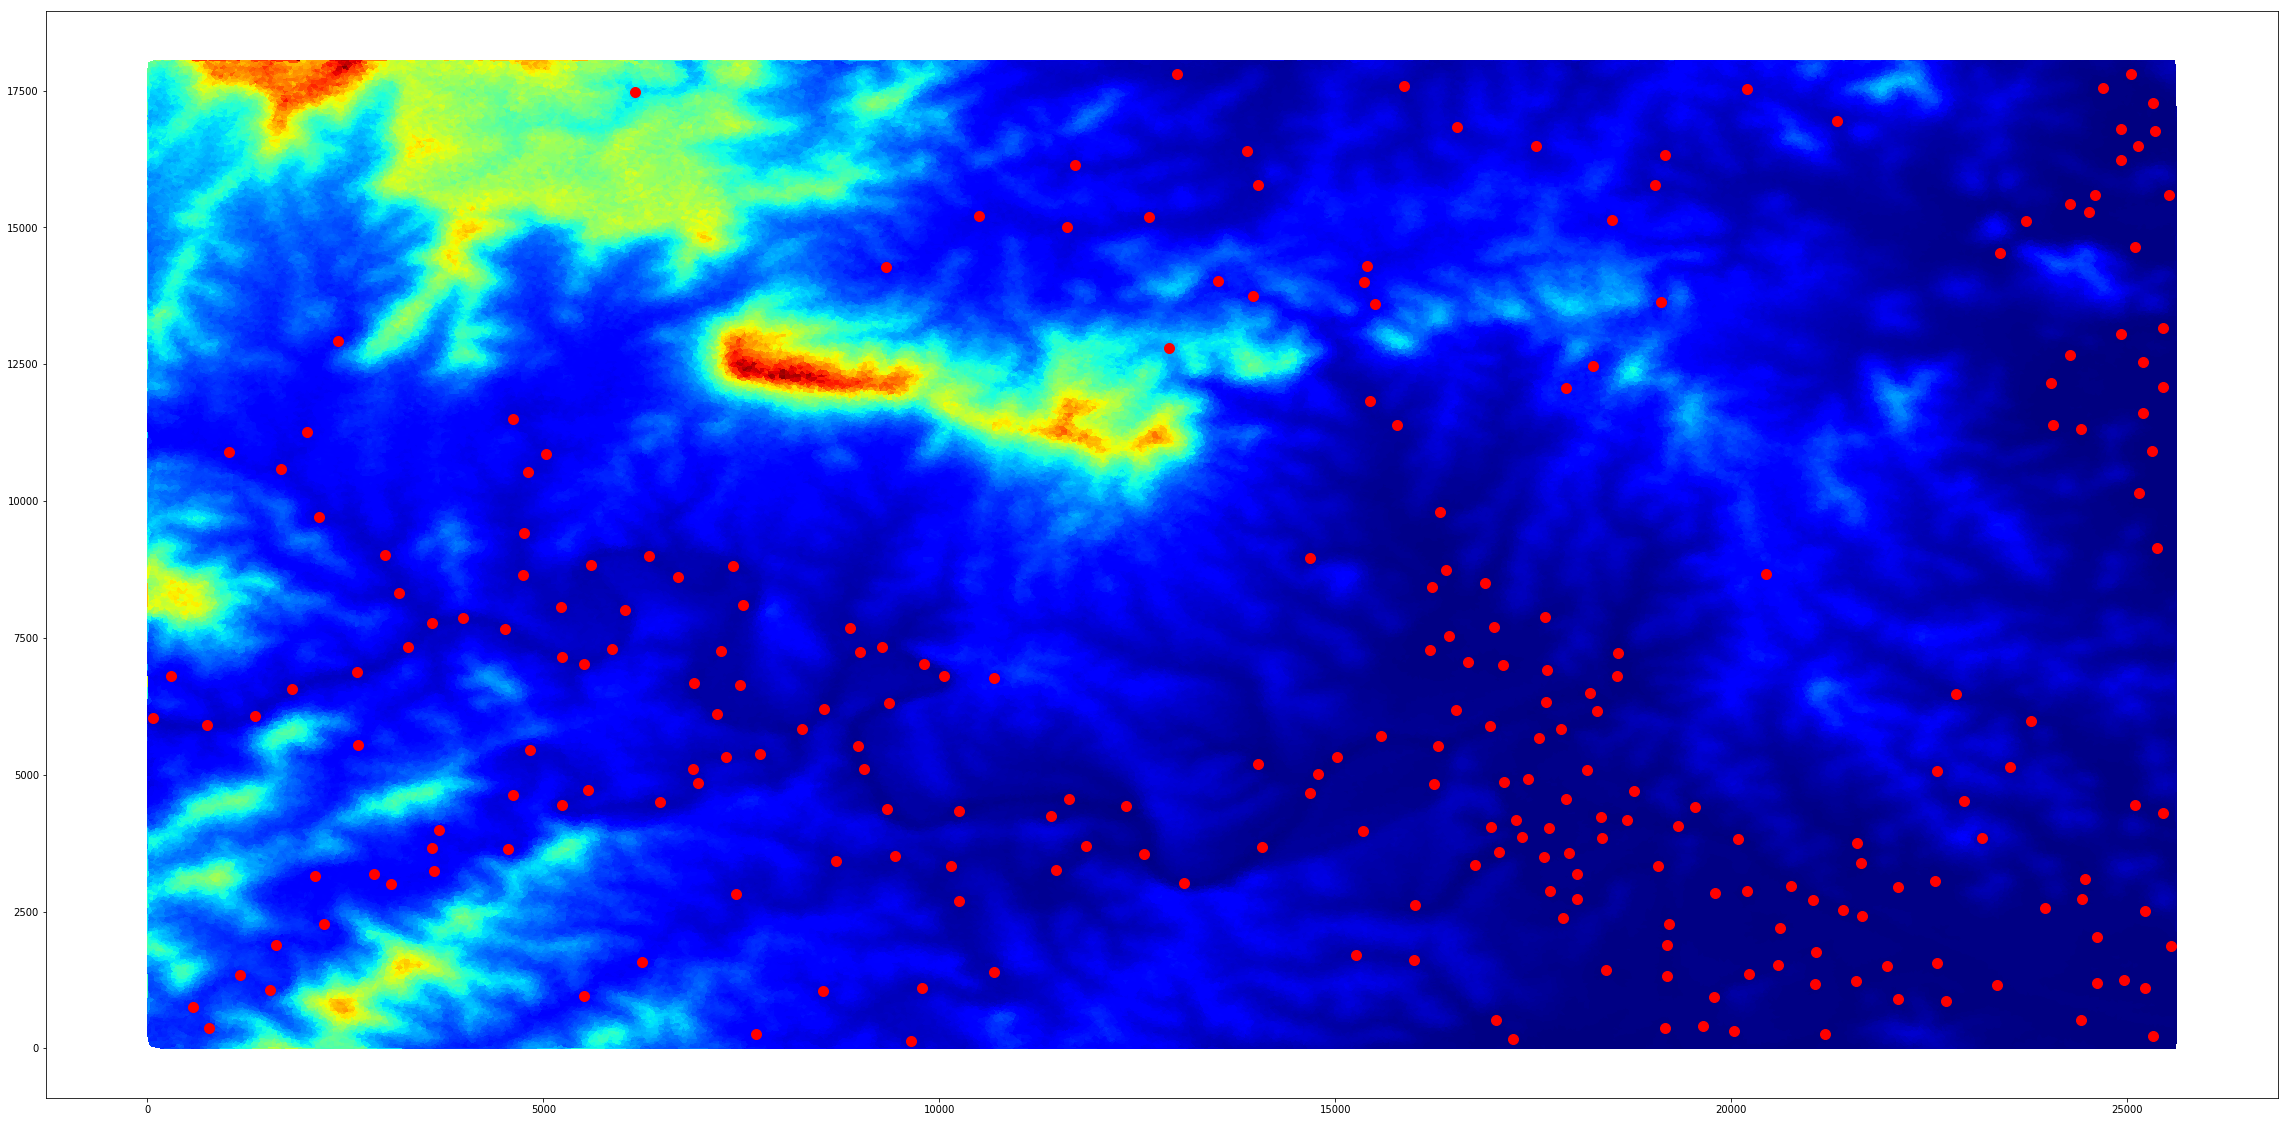

In [32]:

smooth = mesh.local_area_smoothing(mesh.height, centre_weight=0.75, its=3)


fig, (ax1) = plt.subplots(1,1, figsize=(40,20))


ax1.tripcolor(mesh.tri.points[:,0], mesh.tri.points[:,1], mesh.tri.simplices, 
              smooth, linewidth=0.1, cmap='jet')

ax1.scatter(mesh.tri.points[low_points,0], mesh.tri.points[low_points,1], color="Red", s=100)


In [ ]:
low_points = mesh.identify_low_points()
print "Number of low points: ", low_points.shape[0]

h = mesh.height.copy()
smooth = mesh.local_area_smoothing(h, centre_weight=0.75, its=3)

affected_points = mesh.neighbour_cloud[low_points,0:20].flatten()

h[affected_points] = smooth[affected_points]

mesh.update_height(h)




In [ ]:
mesh.slope[low_points]

In [ ]:
mesh.slope.mean()